In [ ]:
import os
from openai import AzureOpenAI

api_base = ' '
api_key= ' '
deployment_name = "gpt-4o"
api_version = "2024-05-01-preview"

client = AzureOpenAI(
    api_key=api_key,
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{deployment_name}"
)

question = ''
answer_to_evaluate = ''


question = 'What is the disease in this picture?'
answer_to_evaluate = '''

Based on the description provided, the disease in the picture is likely Lichen Planus.

Common symptoms include:

Purplish, flat-topped, itchy bumps on the skin: These are often called “purple triad” lesions.

White lines called Wickham striae: These are fine, white lines that can be seen on the surface of the lesions.

Painful white patches or sores in the mouth: This is called oral lichen planus.

Hair loss: In some cases, Lichen Planus can affect the hair follicles, leading to hair thinning or loss.

Nail changes: The nails may become ridged, thin, or even break easily.

Treatment options for Lichen Planus include:

Topical corticosteroids: These creams or ointments can help reduce inflammation and itching.

Oral corticosteroids: These medications are used for more severe cases.

Immunosuppressants: Medications like cyclosporine or methotrexate may be prescribed for severe or persistent cases.

Light therapy (PUVA): This treatment uses ultraviolet light in combination with a medication to reduce inflammation.

Lifestyle modifications: Avoiding triggers like certain medications or irritants can help manage symptoms.

Would you like to know home-care tips?'''


response = client.chat.completions.create(
    model=deployment_name,
    messages=[
        { "role": "system", "content": "You are an expert in dermatology field. You will be given some question answer pairs and asked to evaluate their quality. You should give scores on overall quality, and medical correctness. Your scores should be on 10." },
        { "role": "user", "content": [
            {
                "type": "text",
                "text": "Here is the question and answer pair. Evaluate the quality of the answer and give scores on overall quality, and medical correctness. The scores should be on 10."
                "Question: {} Answer: {}".format(question, answer_to_evaluate)
            },
            {
                "type": "text",
                "text": "Please provide your evaluation in the following format: Overall Quality: X/10, Medical Correctness: Y/10. Do not provide any other text, just the scores."
            }
        ] }
    ],
    max_tokens=2000
)

print(response.choices[0].message.content)

Overall Quality: 7/10, Medical Correctness: 8/10


## WHOLE ANSWERS

In [ ]:
import json
import os
import pandas as pd
import time
from openai import AzureOpenAI
from pathlib import Path


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_ROOT = Path("/content/drive/MyDrive/bitirme_projesi").resolve()
os.chdir(PROJECT_ROOT)

In [ ]:
api_base = ' '
api_key = ' '
deployment_name = "gpt-4o"
api_version = "2024-05-01-preview"

client = AzureOpenAI(
    api_key=api_key,
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{deployment_name}"
)


### MEDGEMMA

In [ ]:
with open("loo_eval_output_medgemma.json", "r") as f:
    data = json.load(f)

results = []

for disease_class, content in data.items():
    for item in content["per_question"]:
        original_question = item["original_question"]
        original_answer = item["original_answer"]
        generated_answer = item["generated_answer_long"]
        retrieved_qa_pairs = item.get("retrieved_qa_pairs", [])

        try:
            response = client.chat.completions.create(
                model=deployment_name,
                messages=[
                    {
                        "role": "system",
                        "content": ("You are an expert in dermatology field. You will be given some question answer pairs and asked to evaluate their quality."
                                    "There will be three inputs: question, original answer and generated answer. By looking to question and original answer, you should score the genrated answer."
                                    "You should give scores on overall accuracy, emphaty and medical consistency. Your scores should be on 10.")
                    },
                    {
                        "role": "user",
                        "content": (
                            f"Question:\n{original_question}"
                            f"Original Answer:\n{original_answer}\n\n"
                            f"Generated Answer:\n{generated_answer}\n\n"
                            "Please evaluate the generated answer. Reply only in the following format:\n"
                            "Accuracy: X/10\nEmphaty: Y/10\nMedical Consistency: Z/10\n"
                            "Do not provide any other text, just the scores."
                        )
                    }
                ],
                max_tokens=200,
                temperature=0.3
            )

            scores = response.choices[0].message.content.strip()
            accuracy_score = None
            emphaty_score = None
            medical_consistency_score = None

            for line in scores.split("\n"):
                if "Accuracy" in line:
                    accuracy_score = int(line.split(":")[1].strip().replace("/10", ""))
                elif "Emphaty" in line:
                    emphaty_score = int(line.split(":")[1].strip().replace("/10", ""))
                elif "Medical Consistency" in line:
                    medical_consistency_score = int(line.split(":")[1].strip().replace("/10", ""))

        except Exception as e:
            print(f"LLM error for {disease_class} - {item['original_question']}: {e}")
            accuracy_score = None
            emphaty_score = None
            medical_consistency_score = None


        results.append({
            "class": disease_class,
            "question": original_question,
            "original_answer": original_answer,
            "generated_answer_long": generated_answer,
            "accuracy_score": accuracy_score,
            "emphaty_score": emphaty_score,
            "medical_consistency_score": medical_consistency_score,
        })

        time.sleep(2)

In [ ]:
medgemma_df = pd.DataFrame(results)

In [ ]:
medgemma_df

,class,question,original_answer,generated_answer_long,accuracy_score,emphaty_score,medical_consistency_score
0,Acne,What are the hallmark clinical features of Acne?,Acne typically presents with characteristic le...,The hallmark clinical features of acne vulgari...,9,8,10
1,Acne,Which factors may trigger or worsen Acne sympt...,"Common aggravators include stress, environment...","Acne vulgaris, or common acne, can be triggere...",9,8,10
2,Acne,How is Acne diagnosed and confirmed by dermato...,Diagnosis relies on clinical examination; in a...,"Okay, I can help with that!\n\nThe diagnosis o...",9,8,9
3,Acne,What first 0line treatments are recommended fo...,First 0line care usually combines topical agen...,"Okay, here's a breakdown of initial first-line...",9,8,9
4,Acne,When should patients with Acne seek urgent med...,"Red flags include rapid progression, systemic ...",Acne typically doesn't require urgent medical ...,9,8,9
...,...,...,...,...,...,...,...
285,Warts,Why does Warts sometimes cause both itching an...,Inflammatory mediators may produce multiple se...,Warts can cause itching (pruritus) and burning...,8,9,8
286,Warts,Can lifestyle habits like diet or stress reduc...,Healthy habits support skin barrier and immune...,While lifestyle modifications like diet and st...,9,10,9
287,Warts,How do topical therapies compare with systemic...,Topicals act locally with fewer systemic effec...,"Okay, here's a comparison of topical and syste...",8,9,7
288,Warts,"Is Warts contagious to family members, and wha...",Most inflammatory dermatoses are not contagiou...,"Yes, warts are contagious. They spread through...",9,9,10


In [ ]:
medgemma_df.to_csv("medgemma_scores.csv", index=False)

In [1]:
general_avg = medgemma_df[["accuracy_score", "emphaty_score", 'medical_consistency_score']].mean()
print("Genel Ortalamalar:")
print(general_avg)

print("\n" + "="*40 + "\n")

class_avg = medgemma_df.groupby("class")[["accuracy_score", "emphaty_score", 'medical_consistency_score']].mean().sort_values(by="medical_consistency_score", ascending=False)

print("Sınıflara Göre Ortalamalar:")
print(class_avg)



Genel Ortalamalar:
accuracy_score               8.431034
emphaty_score                8.634483
medical_consistency_score    8.434483
dtype: float64


Sınıflara Göre Ortalamalar:
                       accuracy_score  emphaty_score  class                                                  
Acne                              8.9            8.2   
Candidiasis                       8.8            8.9   
Lupus                             9.0            8.7   
Tinea                             8.9            8.6   
Lichen_Planus                     8.7            8.7   
Folliculitis                      8.7            8.9   
Contact_Dermatitis                8.8            8.8   
Infestations_Bites                8.6            8.9   
Actinic_Keratosis                 8.4            8.3   
Rosacea                           8.4            8.9   
Warts                             8.7            8.8   
Bullous                           8.6            8.8   
Lichen                            8.4  

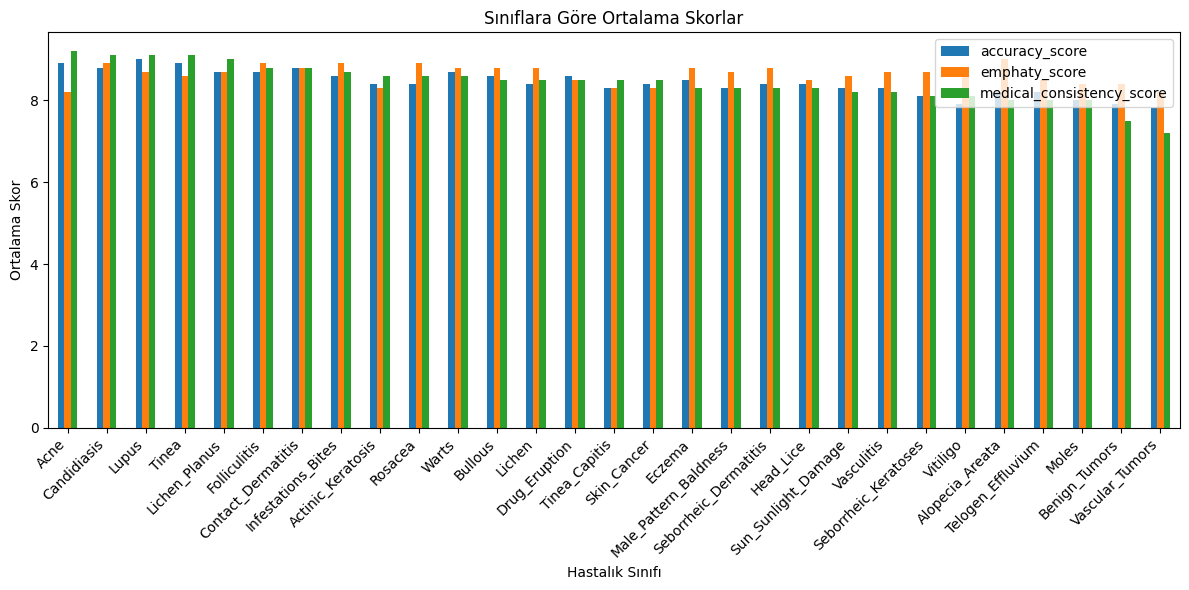

In [ ]:
import matplotlib.pyplot as plt

class_avg.plot(kind="bar", figsize=(12, 6), title="Sınıflara Göre Ortalama Skorlar")
plt.ylabel("Ortalama Skor")
plt.xlabel("Hastalık Sınıfı")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### GEMMA

In [ ]:
from tqdm import tqdm

In [ ]:
with open("loo_eval_output_gemma.json", "r") as f:
    data = json.load(f)

results = []

for disease_class, content in tqdm(data.items()):
    for item in content["per_question"]:
        original_question = item["original_question"]
        original_answer = item["original_answer"]
        generated_answer = item["generated_answer_long"]
        retrieved_qa_pairs = item.get("retrieved_qa_pairs", [])

        try:
            response = client.chat.completions.create(
                model=deployment_name,
                messages=[
                    {
                        "role": "system",
                        "content": ("You are an expert in dermatology field. You will be given some question answer pairs and asked to evaluate their quality."
                                    "There will be three inputs: question, original answer and generated answer. By looking to question and original answer, you should score the genrated answer."
                                    "You should give scores on overall accuracy, emphaty and medical consistency. Your scores should be on 10.")
                    },
                    {
                        "role": "user",
                        "content": (
                            f"Question:\n{original_question}"
                            f"Original Answer:\n{original_answer}\n\n"
                            f"Generated Answer:\n{generated_answer}\n\n"
                            "Please evaluate the generated answer. Reply only in the following format:\n"
                            "Accuracy: X/10\nEmphaty: Y/10\nMedical Consistency: Z/10\n"
                            "Do not provide any other text, just the scores."
                        )
                    }
                ],
                max_tokens=200,
                temperature=0.3
            )

            scores = response.choices[0].message.content.strip()
            accuracy_score = None
            emphaty_score = None
            medical_consistency_score = None

            for line in scores.split("\n"):
                if "Accuracy" in line:
                    accuracy_score = int(line.split(":")[1].strip().replace("/10", ""))
                elif "Emphaty" in line:
                    emphaty_score = int(line.split(":")[1].strip().replace("/10", ""))
                elif "Medical Consistency" in line:
                    medical_consistency_score = int(line.split(":")[1].strip().replace("/10", ""))

        except Exception as e:
            print(f"LLM error for {disease_class} - {item['original_question']}: {e}")
            accuracy_score = None
            emphaty_score = None
            medical_consistency_score = None


        results.append({
            "class": disease_class,
            "question": original_question,
            "original_answer": original_answer,
            "generated_answer_long": generated_answer,
            "accuracy_score": accuracy_score,
            "emphaty_score": emphaty_score,
            "medical_consistency_score": medical_consistency_score,
        })

        time.sleep(2)

100%|██████████| 29/29 [13:44<00:00, 28.42s/it]


In [ ]:
gemma_df = pd.DataFrame(results)

In [ ]:
gemma_df

,class,question,original_answer,generated_answer_long,accuracy_score,emphaty_score,medical_consistency_score
0,Acne,What are the hallmark clinical features of Acne?,Acne typically presents with characteristic le...,"Okay, let’s talk about the characteristic clin...",9,8,10
1,Acne,Which factors may trigger or worsen Acne sympt...,"Common aggravators include stress, environment...","Okay, let’s talk about what can trigger or wor...",9,9,10
2,Acne,How is Acne diagnosed and confirmed by dermato...,Diagnosis relies on clinical examination; in a...,"Okay, let’s talk about how dermatologists conf...",9,9,9
3,Acne,What first 0line treatments are recommended fo...,First 0line care usually combines topical agen...,"Okay, let’s talk about initial over-the-counte...",8,9,9
4,Acne,When should patients with Acne seek urgent med...,"Red flags include rapid progression, systemic ...","Okay, let’s talk about when to seek immediate ...",8,9,8
...,...,...,...,...,...,...,...
285,Warts,Why does Warts sometimes cause both itching an...,Inflammatory mediators may produce multiple se...,"Okay, let’s address why warts can cause itchin...",8,9,8
286,Warts,Can lifestyle habits like diet or stress reduc...,Healthy habits support skin barrier and immune...,Hello there! That’s a really thoughtful questi...,9,10,9
287,Warts,How do topical therapies compare with systemic...,Topicals act locally with fewer systemic effec...,"Okay, let’s compare topical treatments versus ...",8,9,7
288,Warts,"Is Warts contagious to family members, and wha...",Most inflammatory dermatoses are not contagiou...,"Yes, warts *can* be contagious to family membe...",9,10,9


In [ ]:
gemma_df.to_csv('gemma.csv', index=False)

In [2]:
general_avg = gemma_df[["accuracy_score", "emphaty_score", 'medical_consistency_score']].mean()
print("Genel Ortalamalar:")
print(general_avg)

print("\n" + "="*40 + "\n")

class_avg = gemma_df.groupby("class")[["accuracy_score", "emphaty_score", 'medical_consistency_score']].mean().sort_values(by="medical_consistency_score", ascending=False)

print("Sınıflara Göre Ortalamalar:")
print(class_avg)




Genel Ortalamalar:
accuracy_score               8.313793
emphaty_score                9.106897
medical_consistency_score    8.293103
dtype: float64

Sınıflara Göre Ortalamalar:
                       accuracy_score  emphaty_score  class                                                  
Tinea                             8.9            9.2   
Folliculitis                      8.9            9.4   
Candidiasis                       8.9            9.4   
Eczema                            8.9            9.5   
Seborrheic_Dermatitis             8.4            9.3   
Lichen                            8.5            9.1   
Contact_Dermatitis                8.5            9.4   
Actinic_Keratosis                 8.4            8.8   
Acne                              8.4            8.9   
Skin_Cancer                       8.3            9.3   
Lupus                             8.5            9.3   
Bullous                           8.4            9.2   
Tinea_Capitis                     8.6   

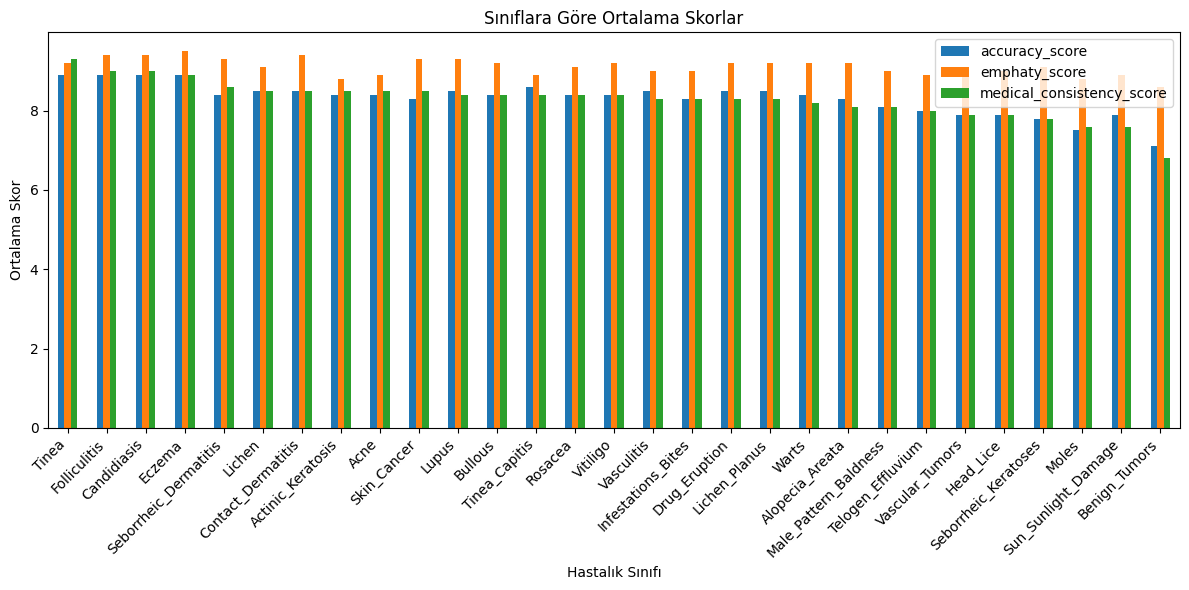

In [ ]:
import matplotlib.pyplot as plt

class_avg.plot(kind="bar", figsize=(12, 6), title="Sınıflara Göre Ortalama Skorlar")
plt.ylabel("Ortalama Skor")
plt.xlabel("Hastalık Sınıfı")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()